In [43]:
import logging
import math
import sys
from abc import abstractmethod
from typing import Dict, Optional, Tuple

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import save_image
from tqdm import tqdm


In [3]:
# AUTO = tf.data.experimental.AUTOTUNE
# IMAGE_SIZE = [512, 512]
# EPOCHS = 2000
# BATCH_SIZE_PER_TPU = 8
# BATCH_SIZE = BATCH_SIZE_PER_TPU * strategy.num_replicas_in_sync
# FOLDERNAME = "v2clean_sample"
# NUM_CLASSES = 81313
EMB_SIZE = 512
EFNS = [
    EfficientNet.from_pretrained("efficientnet-b0", num_classes=EMB_SIZE),
    EfficientNet.from_pretrained("efficientnet-b1"),
    EfficientNet.from_pretrained("efficientnet-b2"),
    EfficientNet.from_pretrained("efficientnet-b3"),
    EfficientNet.from_pretrained("efficientnet-b4"),
    EfficientNet.from_pretrained("efficientnet-b5"),
    EfficientNet.from_pretrained("efficientnet-b6"),
    EfficientNet.from_pretrained("efficientnet-b7", num_classes=EMB_SIZE),
]
EFF_VER = 0


Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b1
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b3
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b5
Loaded pretrained weights for efficientnet-b6
Loaded pretrained weights for efficientnet-b7


In [3]:
class AngularMarginHead(nn.Module):
    def __init__(
        self, feature_size: int, nb_classes: int, s: int, m: float, clip: Optional[bool] = True
    ) -> None:
        super().__init__()
        self.s = s
        self.m = m
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.min_allowed = math.cos(math.pi - m)
        self.clip = clip

        self._cosine = None
        self.sine = None

        self.weight = nn.parameter.Parameter(torch.Tensor(nb_classes, feature_size))
        nn.init.xavier_uniform_(self.weight)

    @property
    def cosine(self):
        return self._cosine

    @cosine.setter
    def cosine(self, value):
        self._cosine = value
        self.sine = torch.sqrt(1 - self.cosine ** 2)

    @abstractmethod
    def positive_cosine_similarity_modulator(self) -> torch.Tensor:
        """
        Positive cosine similarity modulator
        """

    @abstractmethod
    def negative_cosine_similarity_modulator(
        self, cosine_after_positive_modulator: torch.Tensor
    ) -> torch.Tensor:
        """
        Negative cosine similarity modulator
        """

    def forward(self, features: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        self.cosine = F.linear(F.normalize(features), F.normalize(self.weight))
        if self.clip:
            self.cosine = torch.clip(self.cosine, self.min_allowed, 0.99)

        one_hot = torch.zeros_like(self.cosine).to(y.device)
        one_hot.scatter_(1, y.view(-1, 1).long(), 1)

        cosine_after_positive_modulator = self.positive_cosine_similarity_modulator()
        cosine_after_negative_modulator = self.negative_cosine_similarity_modulator(
            cosine_after_positive_modulator
        )

        output = torch.where(
            one_hot == 1, cosine_after_positive_modulator, cosine_after_negative_modulator
        )
        return self.s * output


class ArcFace(AngularMarginHead):
    def __init__(
        self,
        feature_size: int,
        nb_classes: int,
        s: Optional[int] = 64,
        m: Optional[float] = 0.5,
        clip: Optional[bool] = True,
    ) -> None:
        super().__init__(feature_size, nb_classes, s, m, clip)

    def positive_cosine_similarity_modulator(self) -> torch.Tensor:
        """
        Positive cosine modulator for ArcFace is: T(cos(theta)) = cos(theta + m),
        if we expand this expression it becomes: cos(theta)*cos(m) - sin(theta)*sin(m)
        """
        return self.cosine * self.cos_m - self.sine * self.sin_m

    def negative_cosine_similarity_modulator(
        self, cosine_after_positive_modulator: torch.Tensor
    ) -> torch.Tensor:
        """
        There is no modulation for negative cosine similarity in ArcFace
        """
        return self.cosine


In [4]:
class EfficientNetBackbone(nn.Module):
    def __init__(self, feature_size: int):
        super(EfficientNetBackbone, self).__init__()

        self.efficientNet = EFNS[EFF_VER]

    def forward(self, x):
        return self.efficientNet(x)


In [5]:
def setup_logger():
    logger = logging.getLogger("train")
    logger.setLevel(logging.INFO)
    if len(logger.handlers) == 0:
        formatter = logging.Formatter("%(asctime)s | %(message)s")
        ch = logging.StreamHandler(stream=sys.stdout)
        ch.setFormatter(formatter)
        logger.addHandler(ch)
        fh = logging.handlers.WatchedFileHandler("data/train.log")
        fh.setFormatter(formatter)
        logger.addHandler(fh)
    return logger


logger = setup_logger()


class SummaryWriter:
    def __init__(self, nb_epochs: int, nb_batchs: int) -> None:
        self.nb_epochs = nb_epochs
        self.nb_batchs = nb_batchs
        self.epoch = 0

    def set_epoch(self, epoch: int) -> None:
        self.epoch = epoch

    def __call__(self, mode: str, i_batch: int, metrics: Dict[str, float]) -> None:
        summary = f"{mode.title()} Epoch {self.epoch}/{self.nb_epochs} | Batch {i_batch}/{self.nb_batchs} | "
        for metric_name, metric_value in metrics.items():
            summary += f"{metric_name.title()} {metric_value:.2f} | "
        logger.info(summary[:-2])


In [7]:
@torch.no_grad()
def calculate_accuracy(logits: torch.Tensor, y: torch.Tensor) -> float:
    y_pred = torch.argmax(logits, dim=1)
    return torch.mean((y_pred == y).float()).item()


def pass_epoch(
    loader: DataLoader,
    backbone: nn.Module,
    angular_margin: nn.Module,
    optimizer: optim.Optimizer,
    loss_fn: nn.Module,
    summary_writer: SummaryWriter,
    log_interval: int,
    device: str,
) -> Tuple[float]:

    loss = 0
    acc = 0
    with torch.set_grad_enabled(backbone.training):
        for i_batch, (x, y) in enumerate(loader):
            x = x.to(device)
            y = y.to(device)

            embeddings = backbone(x)
            logits = angular_margin(embeddings, y)

            loss_batch = loss_fn(logits, y)
            acc_batch = calculate_accuracy(logits, y)

            if backbone.training:
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()

            loss_batch = loss_batch.item()
            if i_batch % log_interval == 0:
                mode = "train" if backbone.training else "validation"
                summary_writer(mode, i_batch, {"loss": loss_batch, "acc": acc_batch})

            loss += loss_batch
            acc += acc_batch

    loss /= i_batch + 1
    acc /= i_batch + 1
    return loss, acc


def train(
    train_loader: DataLoader,
    validation_loader: DataLoader,
    angular_margin: nn.Module,
    loss_fn: nn.Module,
    feature_size: int,
    lr: float,
    nb_epochs: int,
    log_interval: int,
    early_stop_after: int,
    device: str,
) -> nn.Module:

    backbone = EfficientNetBackbone(feature_size)
    backbone.to(device)
    angular_margin.to(device)

    backbone_state_dict = backbone.state_dict()
    head_state_dict = angular_margin.state_dict()

    optimizer = optim.Adam(list(backbone.parameters()) + list(angular_margin.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

    summary_writer = SummaryWriter(nb_epochs, len(train_loader))


    min_loss = math.inf
    for epoch in range(nb_epochs):
        summary_writer.set_epoch(epoch + 1)

        backbone.train()
        angular_margin.train()

        loss, acc = pass_epoch(
            train_loader,
            backbone,
            angular_margin,
            optimizer,
            loss_fn,
            summary_writer,
            log_interval,
            device,
        )
        logger.info(f"Train Epoch Loss: {loss:.2f} | Accuracy: {acc:.2f}\n")

        backbone.eval()
        angular_margin.eval()
        loss, acc = pass_epoch(
            validation_loader,
            backbone,
            angular_margin,
            optimizer,
            loss_fn,
            summary_writer,
            log_interval,
            device,
        )
        acc = round(acc, 2)
        logger.info(f"Validation Epoch Loss: {loss:.2f} | Accuracy: {acc}\n")

        if loss > min_loss:
            min_loss = loss
            early_stop_counter = 0
            backbone_state_dict = backbone.state_dict()
            head_state_dict = angular_margin.state_dict()
        else:
            early_stop_counter += 1

        if early_stop_counter == early_stop_after:
            break

        scheduler.step(loss)

    backbone.load_state_dict(backbone_state_dict)
    angular_margin.load_state_dict(head_state_dict)
    return backbone, angular_margin, min_loss


@torch.no_grad()
def extract_embeddings(
    experiment_name: str, test_loader: DataLoader, backbone: nn.Module, device: str
) -> Tuple[np.ndarray]:
    logger.info(f"Extracting embeddings with the model with: {experiment_name}")
    log_interval = len(test_loader) // 5
    test_embeddings = []

    backbone.eval()
    for i_batch, x in enumerate(test_loader):
        x = x.to(device)

        test_embeddings.append(backbone(x))

        if i_batch % log_interval == 0:
            logger.info(f"Extracting embedings Batch {i_batch}/{len(test_loader)}")

    return torch.cat(test_embeddings).cpu().numpy()


In [30]:
transformations = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(
            mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
            std=[0.229 * 255, 0.224 * 255, 0.225 * 255],
        ),
    ]
)

In [14]:
def get_path(folder, image_id):
    return os.path.join(folder, f"{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.jpg")

In [39]:
import os
import pandas as pd
from torch.utils.data import Dataset


class GoogleLandmarkDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        landmarks = sorted(list(set(self.img_labels["landmark_id"])))
        self.landmark_id_to_label = {landmarks[i]: i for i in range(len(landmarks))}
        self.img_dir = img_dir
        self.num_classes = len(landmarks)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = get_path(self.img_dir, self.img_labels.iloc[idx, 0])
        image = cv.imread(img_path)
        label = self.landmark_id_to_label[self.img_labels.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [17]:
batch_size = 256

dataset = GoogleLandmarkDataset(
    img_dir="./data/train",
    annotations_file="./data/train.csv",
    transform=transformations,
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size


train_dataset, validation_dataset = random_split(dataset, [train_size, val_size])


train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=0,
    drop_last=True,
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
    drop_last=False,
)


In [18]:
# Head parameters
m = 0.5  # For all
s = 64  # For all
alpha = 0.99  # For CurricularFace
t = 1.2  # For MV-Arc-Softmax

nb_epochs = 50
lr = 1e-3
early_stop_after = 11
feature_size = 512  # Embeddings size
log_interval = 50

nb_classes = dataset.num_classes

device = "cuda" if torch.cuda.is_available() else "cpu"

logger.info(f"Using device: {device}")


2022-01-17 09:46:03,643 | Using device: cpu


In [ ]:
backbone, head, acc = train(
    train_loader,
    validation_loader,
    ArcFace(feature_size, nb_classes, s, m),
    nn.CrossEntropyLoss(),
    feature_size,
    lr,
    10,
    1,
    early_stop_after,
    device,
)

plt.figure(num=None, figsize=(15, 15), dpi=80, facecolor="w", edgecolor="k")
plt.plot(head.ts)
plt.title("t values during training in CurricularFace")
plt.xlabel("step")
plt.ylabel("t")
logger.info(60 * "-" + "\n")


In [57]:
import math
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from src.models.angular_margin import ArcFace
from src.models.backbone import EfficientNetBackbone
from src.utils.logger import SummaryWriter, logger
from src.data.utils import get_path
from torch.utils.data import DataLoader


In [13]:
efficient_net = EfficientNet.from_pretrained("efficientnet-b0", num_classes=512)
backbone = EfficientNetBackbone(512, efficient_net)
backbone = EfficientNetBackbone(512, backbone)
angular_margin = ArcFace(512, 10001, s=64, m=0)


Loaded pretrained weights for efficientnet-b0


In [50]:
checkpoint = torch.load(
    os.path.join("../models", "standard_model_en-b0_224", "latest_checkpoint.pth"),
    map_location=torch.device("cpu"),
)
backbone.load_state_dict(checkpoint["backbone_state_dict"])
angular_margin.load_state_dict(checkpoint["best_head_state_dict"])


<All keys matched successfully>

In [62]:
class TestLandmarkDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.imgs = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image_id = self.imgs.iloc[idx, 0]
        img_path = get_path(self.img_dir, image_id)
        image = cv.imread(img_path)
        if self.transform:
            image = self.transform(image)
        return image, image_id

In [63]:
transformations = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(
            mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
            std=[0.229 * 255, 0.224 * 255, 0.225 * 255],
        ),
    ]
)

In [64]:
test_dataset = TestLandmarkDataset("../test/test.csv", "../test", transformations)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    drop_last=False
)

In [92]:
@torch.no_grad()
def extract_embeddings(
    test_loader: DataLoader, backbone: nn.Module, device: str, max_batch: int = None
) -> Tuple[np.ndarray]:
    log_interval = len(test_loader) // 10
    test_embeddings = []
    test_ids = []

    backbone.eval()
    for i_batch, (x,y) in enumerate(test_loader):
        x = x.to(device)

        test_embeddings.append(backbone(x))
        test_ids += y

        if i_batch % log_interval == 0:
            logger.info(f"Extracting embedings Batch {i_batch}/{len(test_loader)}")

        if max_batch is not None and i_batch > max_batch:
            break

    return torch.cat(test_embeddings).cpu().numpy(), np.array(test_ids)


In [106]:
embeddings, ids = extract_embeddings(test_loader, backbone, "cpu", 20)

2022-01-21 14:15:51,322 | Extracting embedings Batch 0/368


In [111]:
np.save("../test/embeddings.npy", embeddings)
np.save("../test/ids.npy", ids)

In [108]:
from sklearn.metrics.pairwise import cosine_similarity

def find_best_neighbors(index_ids, index_embeddings, query_embedding):

    similarities = cosine_similarity(query_embedding, index_embeddings)

    return index_ids[np.argsort(similarities[0])[-20:][::-1]]


In [76]:
@torch.no_grad()
def get_single_embedding(image_path):
    image = cv.imread(image_path)
    image = transformations(image)
    image = image.unsqueeze(0)
    image = image.to("cpu")
    return backbone(image).cpu().numpy()

In [112]:
index_ids = np.load("../test/ids.npy")
index_embeddings = np.load("../test/embeddings.npy")
embedding = get_single_embedding("../train/0/0/0/000a0aee5e90cbaf.jpg")

results = find_best_neighbors(index_ids, index_embeddings, embedding)

In [114]:
query_data = []

images_paths = glob.glob(os.path.join("..", "train", "*/*/*/*.jpg"))
for image in images_paths:
    image_name = os.path.splitext(os.path.basename(image))[0]
    
    query_data.append(image_name)

In [41]:
import glob

test_data = []

images_paths = glob.glob(os.path.join("..", "test", "*/*/*/*.jpg"))
for image in images_paths:
    image_name = os.path.splitext(os.path.basename(image))[0]
    
    test_data.append(image_name)

test_df = pd.DataFrame(test_data, columns=["image_id"])
test_df.to_csv("../test/test.csv", index=False)

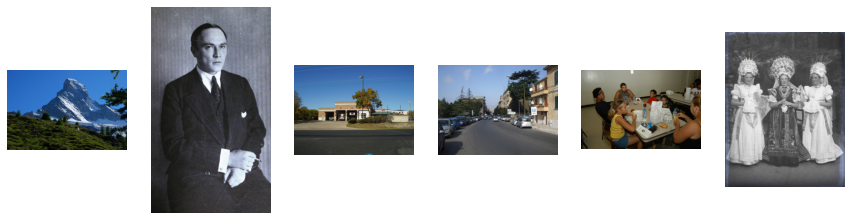

In [143]:
import matplotlib.image as mpimg

sample = 105

image_id = query_data[sample]

embedding = get_single_embedding(get_path("../train", image_id))

results = find_best_neighbors(index_ids, index_embeddings, embedding)


fig, axs = plt.subplots(1, 6, figsize=(15, 8))

img = mpimg.imread(get_path("../train", image_id))
axs[0].imshow(img)
axs[0].set_axis_off()


for i in range(5):
    img = mpimg.imread(get_path("../test", results[i]))
    axs[i+1].imshow(img)
    axs[i+1].set_axis_off()


plt.show()